<a href="https://colab.research.google.com/github/masta-g3/robinmodel/blob/main/robinmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Predictive Features
We use the TA library to generate a variety of technical analysis indicators for a given stock. We then use these signals as input to a Random Forest model, so we can evaluate their predictive power and identify which features are most important.

In [571]:
!pip install yfinance >> /dev/null
!pip install mplcyberpunk >> /dev/null
!pip install tsmoothie >> /dev/null
!pip install ta >> /dev/null
!pip install pykalman >> /dev/null
print('Done with installs.')

Done with installs.


In [573]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import mplcyberpunk

from ta import add_all_ta_features
from tsmoothie.smoother import LowessSmoother, KalmanSmoother
from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
plt.style.use("cyberpunk")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load a Ticker & Get Features
The price time series for a stock has a significant day-to-day noise component, which might confuse our model. We try to reduce this noise by using Kahlman filter smoothing.


In [756]:
## Ticker data.
ticker = 'NVDA'
stock = yf.Ticker(ticker)
stock_df = stock.history(start='2020-01-01', end='2021-01-01')

# smoother = LowessSmoother(smooth_fraction=0.025, iterations=1)
# stock_df['Close_Smooth'] = smoother.smooth(stock_df['Close']).smooth_data[0]

smoother = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = stock_df.iloc[0]['Close'],
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=0.5)

mean, cov = smoother.filter(stock_df['Close'])
stock_df['Close_Smooth'] = mean

## Add all TA features.
stock_df = add_all_ta_features(
    stock_df, open="Open", high="High", low="Low",
    close="Close_Smooth", volume="Volume")

stock_df.drop(columns=['trend_psar_up', 'trend_psar_down', 'trend_stc',
                       'trend_mass_index', 'momentum_tsi', 'trend_trix'], inplace=True)

idx_last_ta = stock_df.shape[1]
stock_df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Smooth,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,...,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900,0.0,0,522.210325,-5.661882e+08,673594600,0.156159,-2.704475e+06,34.275503,880.972026,-60.914800,32273.827481,1549.377279,526.032112,12.494097,529.567403,543.027611,516.107196,5.083473,0.226710,0.0,0.0,525.715284,536.740281,514.690288,4.194284,0.341045,0.0,0.0,510.529999,549.25,529.889999,7.311629,0.301661,2.653763,-2.929915,...,528.619980,14.906977,14.627594,20.163365,0.940394,1.011554,-0.071159,-72.760890,-2.449656,-10.288362,-7.060668,-3.227694,523.365005,529.889999,526.627502,539.670563,533.699830,531.587943,36.0,96.0,-60.0,0.0,0.0,42.430136,0.377014,0.125671,0.069671,63.280104,41.670804,32.374137,-58.329196,-9.134880,527.581953,0.062237,-14.742134,-13.753180,-0.988954,0.697986,0.695562,118.028443
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500,0.0,0,522.205168,-5.652868e+08,668788100,0.169447,-2.321662e+06,34.441837,-174.799552,14.399317,39283.380901,1549.361981,526.165898,12.188688,528.793453,542.076726,515.510180,5.023993,0.252008,0.0,0.0,524.669308,535.739306,513.599309,4.219800,0.388702,0.0,0.0,510.529999,549.25,529.889999,7.322330,0.301528,2.540536,-2.990882,...,528.144809,14.978730,13.881257,19.134579,0.979074,0.970731,0.008343,-71.263515,1.975411,-11.655000,-7.508473,-4.146528,523.365005,529.889999,526.627502,539.670563,536.898881,531.587943,32.0,92.0,-60.0,0.0,0.0,42.425052,0.376621,0.251212,0.128261,60.152734,41.652409,37.360126,-58.347591,-9.808851,527.099210,-0.931970,-14.629977,-13.928539,-0.701437,-0.000987,-0.000987,118.026290


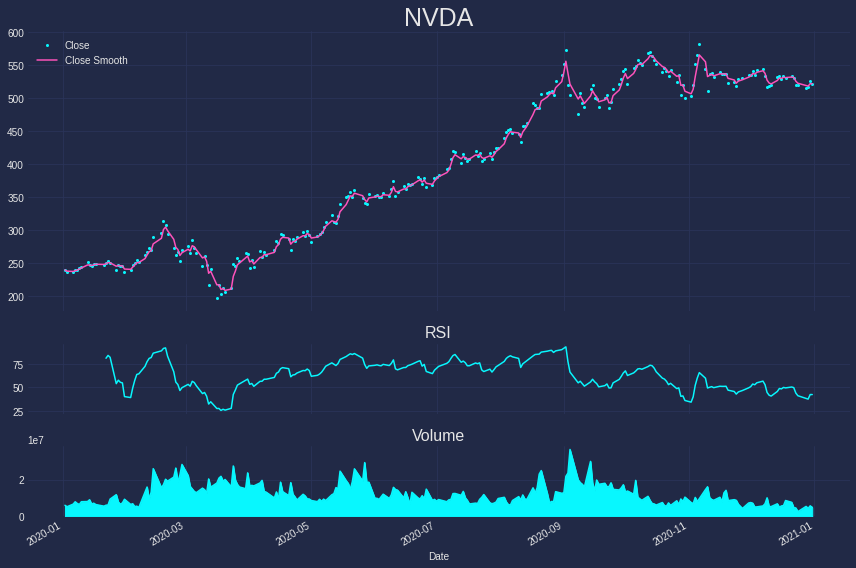

In [757]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=3, sharex=True,
                        gridspec_kw={'height_ratios':[4,1,1]})

## Prices and smoothed prices.
ax = axs[0]
stock_df['Close'].plot(ax=ax, ls='', marker='o', markersize=2, label='Close')
stock_df['Close_Smooth'].plot(ax=ax, ls='-', markersize=2, label='Close Smooth')
ax.legend()
ax.set_title(ticker, size=25)

## Some indicator.
ax = axs[1]
stock_df['momentum_rsi'].plot(ax=ax)
ax.set_title('RSI', size=16)

## Volume.
ax = axs[2]
stock_df['Volume'].plot.area(ax=ax)
ax.set_title('Volume', size=16)

fig.tight_layout();

## Train Random Forest

In [758]:
feats = stock_df.columns[8:idx_last_ta].tolist()

## Calculate returns of smoothed prices.
stock_df['ret'] = stock_df['Close'].pct_change()
stock_df['ret_smooth'] = stock_df['Close_Smooth'].pct_change()

## Next day returns.
stock_df['ret_next'] = stock_df['ret'].shift(-1)
stock_df['ret_type'] = 0
stock_df.loc[stock_df['ret_next'] > 0.01, 'ret_type'] = 1
stock_df.loc[stock_df['ret_next'] < -0.01, 'ret_type'] = -1

## Next day returns (smooth).
stock_df['ret_next_smooth'] = stock_df['ret_smooth'].shift(-1)
stock_df['ret_type_smooth'] = 0
stock_df.loc[stock_df['ret_next_smooth'] > 0.01, 'ret_type_smooth'] = 1
stock_df.loc[stock_df['ret_next_smooth'] < -0.01, 'ret_type_smooth'] = -1

In [759]:
## Check if we have many nulls.
stock_df[feats].isnull().sum().sort_values().tail(3)

momentum_ppo_signal    33
momentum_ppo_hist      33
trend_macd_diff        33
dtype: int64

In [760]:
## Create model input data.
model_df = stock_df[feats + ['Close', 'Close_Smooth', 'ret',
                             'ret_smooth','ret_type_smooth']].dropna()
model_df.loc[model_df['ret_type_smooth'] == -1, 'ret_type_smooth'] = 0

## Divide dataset.
train_range = np.arange(0, np.ceil(model_df.shape[0] * 0.8))
test_range = np.arange(train_range[-1]+1, model_df.shape[0])

train_df = model_df.iloc[train_range]
test_df = model_df.iloc[test_range]

In [763]:
clf = RandomForestClassifier(n_estimators=500)

clf.fit(train_df[feats], train_df['ret_type_smooth'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.4).astype(float)

print('Training accuracy:',
      sum(train_df['ret_type_smooth'] == train_pred) / len(train_pred))

print('Test accuracy:',
      sum(test_df['ret_type_smooth'] == test_pred) / len(test_pred))

print('Positive test bets:', sum(test_pred))

Training accuracy: 1.0
Test accuracy: 0.225
Positive test bets: 32.0


In [764]:
importance_df = pd.DataFrame(zip(feats, clf.feature_importances_))
importance_df.sort_values(1, ascending=False).head(7)

,0,1
75,others_dlr,0.038141
74,others_dr,0.035391
32,trend_macd_signal,0.029530
7,volume_vpt,0.029491
5,volume_em,0.023739
38,trend_adx,0.023207
45,trend_dpo,0.023048


TRAINING:
Max return: 1.864
Actual return: 1.864

TEST:
Max return: 0.078
Actual return: -0.07


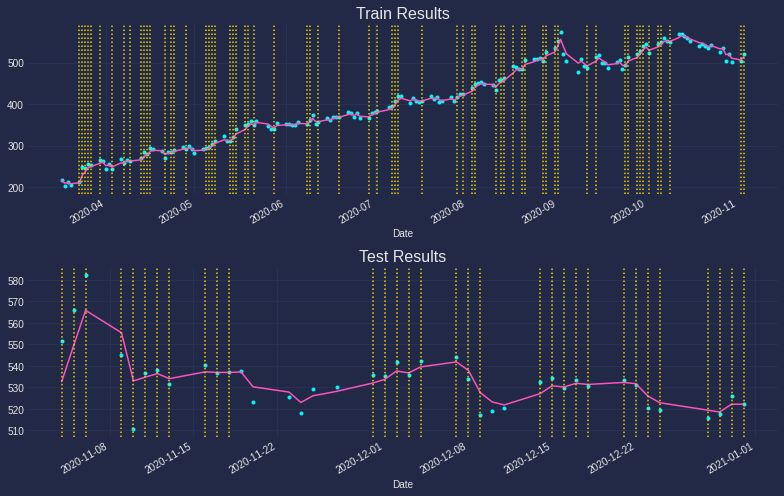

In [765]:
## Train.
fig, axs = plt.subplots(figsize=(11, 7), nrows=2, sharey=False)

ax = axs[0]
train_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
train_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
ax.set_title('Train Results', size=16)

print('TRAINING:')
print('Max return:', (train_df['ret'].shift(-1) * train_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (train_df['ret'].shift(-1) * train_pred).sum().round(3))

## Test.
ax = axs[1]
test_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
test_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
ax.set_title('Test Results', size=16)
fig.tight_layout()

print('\nTEST:')
print('Max return:', (test_df['ret'].shift(-1) * test_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (test_df['ret'].shift(-1) * test_pred).sum().round(3))

In [689]:
## Lowess smoothers.
smoother = LowessSmoother(smooth_fraction=0.025, iterations=1)
stock_df['lowess_short'] = smoother.smooth(stock_df['Close']).smooth_data[0]

smoother = LowessSmoother(smooth_fraction=0.05, iterations=1)
stock_df['lowess_long'] = smoother.smooth(stock_df['Close']).smooth_data[0]

## SMAs.
stock_df['sma_5'] = stock_df['Close'].rolling(5).mean()
stock_df['sma_10'] = stock_df['Close'].rolling(10).mean()

## Divergence.
stock_df['lowess_div'] = (stock_df['lowess_long'] - stock_df['lowess_short']) / stock_df['lowess_short']
stock_df['sma_div'] = (stock_df['sma_10'] - stock_df['sma_5']) / stock_df['sma_5']

In [690]:
## Calculate returns of smoothed prices.
stock_df['ret'] = stock_df['Close'].pct_change()
stock_df['ret_smooth'] = stock_df['lowess_short'].pct_change()

hl = np.log(0.5) / np.log(0.94)
stock_df['ret_std'] = stock_df['ret'].ewm(halflife=hl).std()
stock_df['ret_std_smooth'] = stock_df['ret_smooth'].ewm(halflife=hl).std()

## Next day returns.
stock_df['ret_next'] = stock_df['ret'].shift(-1)
stock_df['ret_type'] = 0
stock_df.loc[stock_df['ret_next'] > 0.01, 'ret_type'] = 1
stock_df.loc[stock_df['ret_next'] < -0.01, 'ret_type'] = -1

## Next day returns (smooth).
stock_df['ret_next_smooth'] = stock_df['ret_smooth'].shift(-1)
stock_df['ret_type_smooth'] = 0
stock_df.loc[stock_df['ret_next_smooth'] > 0.01, 'ret_type_smooth'] = 1
stock_df.loc[stock_df['ret_next_smooth'] < -0.01, 'ret_type_smooth'] = -1

In [691]:
## On balance volume.
stock_df['obv'] = (np.sign(stock_df['ret']) * stock_df['Volume']).cumsum()
stock_df['obv_ret'] = stock_df['obv'].pct_change().clip(-.5, .5)

In [337]:
## RSI.
stock_df['rsi'] = RSIIndicator(stock_df["Close"], window=14).rsi()

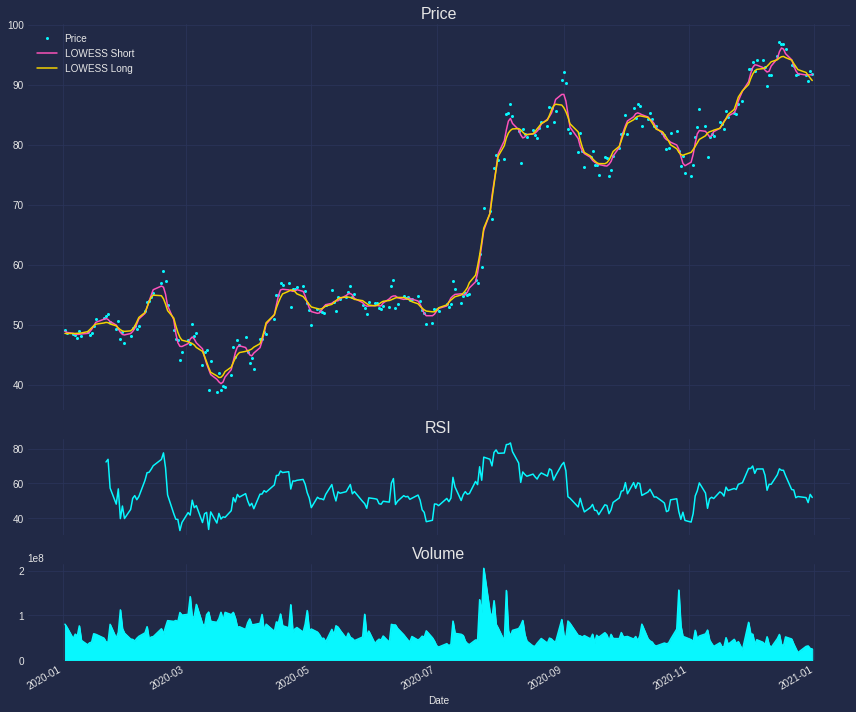

In [338]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, sharex=True,
                        gridspec_kw={'height_ratios':[4,1,1]})

## Prices and smoothed prices.
ax = axs[0]
stock_df['Close'].plot(ax=ax, ls='', marker='o', markersize=2, label='Price')
stock_df['lowess_short'].plot(ax=ax, label='LOWESS Short')
stock_df['lowess_long'].plot(ax=ax, label='LOWESS Long')

ax.legend()
ax.set_title('Price', size=16)

## Some indicator.
ax = axs[1]
stock_df['rsi'].plot(ax=ax)
ax.set_title('RSI', size=16)

## Volume.
ax = axs[2]
stock_df['Volume'].plot.area(ax=ax)
ax.set_title('Volume', size=16)

fig.tight_layout();

## Visualizing Predicitve Features

In [339]:
feats = ['sma_div', 'ret_std', 'obv_ret','rsi']

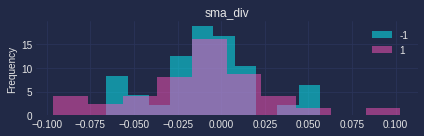

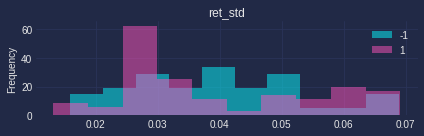

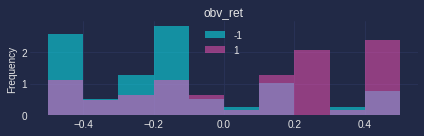

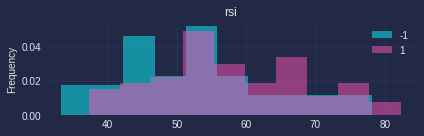

In [340]:
for feat in feats:
  fig, ax = plt.subplots(figsize=(6,2))

  plot_df = stock_df[stock_df['ret_type_smooth'] != 0]
  plot_df.groupby('ret_type_smooth')[feat].plot.hist(ax=ax, alpha=0.5,
                                                     density=True)
  ax.legend()
  ax.set_title(feat)
  fig.tight_layout();

## Feature Model

In [342]:
## Create model input data.
model_df = stock_df[feats + ['Close', 'ret', 'ret_type', 'ret_type_smooth']].dropna()
model_df.loc[model_df['ret_type'] == -1, 'ret_type'] = 0
model_df.loc[model_df['ret_type_smooth'] == -1, 'ret_type_smooth'] = 0

## Divide dataset.
train_range = np.arange(0, np.ceil(model_df.shape[0] * 0.8))
test_range = np.arange(train_range[-1]+1, model_df.shape[0])

train_df = model_df.iloc[train_range].drop(columns=['ret_type'])
test_df = model_df.iloc[test_range].drop(columns=['ret_type_smooth'])

## Rename target.
train_df.rename(columns={'ret_type_smooth':'tgt'}, inplace=True)
test_df.rename(columns={'ret_type':'tgt'}, inplace=True)

In [356]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3)

clf.fit(train_df[feats], train_df['tgt'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.5).astype(float)

print(sum(train_df['tgt'] == train_pred) / len(train_pred))
print(sum(test_df['tgt'] == test_pred) / len(test_pred))

0.8385416666666666
0.6666666666666666


In [357]:
list(zip(feats, clf.feature_importances_))

[('sma_div', 0.2503888674200039),
 ('ret_std', 0.3277695753964216),
 ('obv_ret', 0.23155498857920398),
 ('rsi', 0.19028656860437054)]

1.1896178832752127
0.30167688255966185


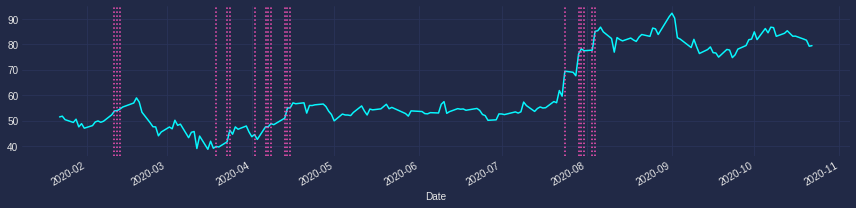

In [358]:
fig, ax = plt.subplots(figsize=(12, 3))
train_df['Close'].plot(ax=ax)
[ax.axvline(v, c=colors[1], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
fig.tight_layout()

print((train_df['ret'].shift(-1) * train_df['tgt']).sum())
print((train_df['ret'].shift(-1) * train_pred).sum())

0.48079691668493685
0.0


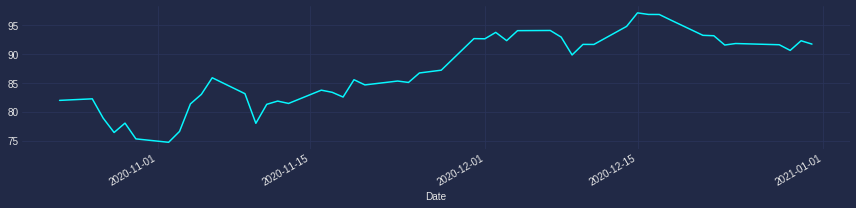

In [359]:
fig, ax = plt.subplots(figsize=(12, 3))
test_df['Close'].plot(ax=ax)
[ax.axvline(v, c=colors[1], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
fig.tight_layout()

print((test_df['ret'].shift(-1) * test_df['tgt']).sum())
print((test_df['ret'].shift(-1) * test_pred).sum())